In [2]:
# similar sound-producing mechanism (hyperacoustics)
acoustic_dict = {
    "impact": ["bump", "drop", "fall", "bounce", "clap", "slam", "clang", "step", "punch"],
    "explosion": ["blast", "explode", "bang", "blow up", "burst"],
    "vocal": ["talk", "scream", "hiss", "yell", "chant", "conversation", "murmur", "shout"],
    "nose": ["wheeze", "sneeze", "snort", "snore", "smell"],
}

# similar semantics
semantic_dict = {
    "locomotion": ["walk", "gallop", "run" , "march", "jump", "move"],
    "dog": ["howl", "bark", "snarl", "growl", "whimper", "scratch", "pant"],
    "vehicle": ["rev", "drive", "pass", "accelerate", "brake"],
    "complex_sound" : ["fight", "box", "gunshot", "destruction", "accident", "wrestle", "bowl", "exercise"]
}

In [5]:
import pandas as pd
import gensim

from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import pdist, squareform
from scipy.stats import zscore

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# OWL2Vec* word embedding model
o2vmodel = gensim.models.Word2Vec.load(
    ".ontology.embeddings")

# Word2Vec word embedding model (300 dim) 
w2vmodel = gensim.models.KeyedVectors.load_word2vec_format(
    r'C:\Users\Martin\Documents\research_internship\Datasets\GoogleNews-vectors-negative300.bin.gz', binary=True)

In [6]:
# function to create df of words and their embeddings for later plotting
def create_df(model, dict):   
    dictionary_words = []
    for word in dict.values():
        dictionary_words.extend(word) # list of words used as index
        
    category = []
    for key, val in dict.items():
        category.extend([*[str(key)]*len(val)]) # list of category memberships
        
    tuples = list(zip(category, dictionary_words))

    # commands working for fully pretrained models 
    if type(model) == gensim.models.word2vec.Word2Vec:
        #word_list = [word for word in dictionary_words if word in model.wv.key_to_index]
        filtered_tuples = [tup for tup in tuples if tup[1] in model.wv.index_to_key]
        vectors = [model.wv.get_vector(word) for word in dictionary_words if word in model.wv.index_to_key] 
    # commands working for custom models
    else:
        #word_list = [word for word in words if word in model.key_to_index] 
        filtered_tuples = [tup for tup in tuples if tup[1] in model.index_to_key]
        vectors = [model.get_vector(word) for word in dictionary_words if word in model.index_to_key] 
        
    index = pd.MultiIndex.from_tuples(filtered_tuples)

    df = pd.DataFrame(data=vectors, index=index)
    return df

In [7]:
w2v_sem_df = create_df(w2vmodel, semantic_dict)
w2v_aco_df = create_df(w2vmodel, acoustic_dict)

o2v_sem_df = create_df(o2vmodel, semantic_dict)
o2v_aco_df = create_df(o2vmodel, acoustic_dict)

In [8]:
len(w2v_sem_df)

26

In [9]:
w2v_sem_df.head(n=5)

0         1         2         3         4         5    \
locomotion walk    0.000248 -0.008728 -0.125000  0.457031 -0.060059 -0.051270   
           gallop  0.129883  0.265625 -0.234375 -0.010986  0.133789 -0.365234   
           run    -0.073242  0.083984 -0.007446  0.039795  0.052002 -0.208008   
           march   0.081543  0.279297 -0.018555  0.210938  0.119141 -0.378906   
           jump    0.052002  0.036133 -0.103516  0.128906 -0.004242 -0.373047   

                        6         7         8         9    ...       290  \
locomotion walk   -0.048584 -0.208984 -0.154297  0.140625  ... -0.225586   
           gallop  0.189453  0.074707 -0.029419  0.137695  ... -0.025513   
           run     0.011963 -0.225586  0.020020  0.263672  ... -0.032227   
           march  -0.031738 -0.134766 -0.261719  0.161133  ...  0.035889   
           jump    0.037598  0.168945  0.094727  0.193359  ...  0.050781   

                        291       292       293       294       295       296  \
locomotion walk    0.310547 -0.175781  0.141602  0.072266  0.059814 -0.037354   
           gallop  0.011719 -0.246094  0.417969  0.169922  0.188477  0.217773   
           run     0.151367 -0.257812  0.075684  0.080566 -0.065918 -0.006805   
           march  -0.129883 -0.084473  0.192383  0.208008  0.132812  0.052979   
           jump    0.184570 -0.310547  0.039307 -0.180664 -0.337891 -0.110840   

                        297       298       299  
locomotion walk   -0.279297 -0.079590 -0.073242  
           gallop  0.144531 -0.107422 -0.223633  
           run    -0.170898 -0.150391 -0.054199  
           march  -0.182617  0.003113  0.110840  
           jump    0.104004  0.024536 -0.056641  

[5 rows x 300 columns]

In [15]:
# cosine similarity matrix
# 1-distance matrix with the cosine distance as a metric = similarity matrix
def create_similarity_matrix_df(df, metric):
    vector = df.to_numpy()
    # matrix = 1-pairwise_distances(df.to_numpy(), metric=metric) # similarity based on euclidean, cosine or correlation
    
    matrix = 1-squareform(pdist(zscore(df, axis=0), metric))

    matrix_df = pd.DataFrame(data=matrix, columns=df.index, index=df.index)
    
    # matrix_df.style.set_properties(**{'text-align': 'left'})
    return matrix_df.style.background_gradient(axis=None, cmap='RdBu') # changing color

In [16]:
create_similarity_matrix_df(w2v_sem_df, "cosine")

In [17]:
create_similarity_matrix_df(w2v_aco_df, "cosine")

In [18]:
create_similarity_matrix_df(o2v_sem_df, "cosine")

In [19]:
create_similarity_matrix_df(o2v_aco_df, "cosine")

In [20]:
# standard dimensionality reduction setup (tSNE, PCA?)
def initiate_tsne(df):
    tsne = TSNE(n_components = 2, 
                perplexity = 10, 
                learning_rate = 400, 
                init = 'random',
                metric= "cosine",
                random_state = 10,
                square_distances=(True))

    tsne_df = tsne.fit_transform(df)
    return tsne_df

In [21]:
# plotting function
def plotting(df, tsne_df, title):

    plt.scatter(tsne_df[:,0],
                tsne_df[:,1],
                s=30,
                alpha = 1)

    # Initialize list of texts
    texts = []
    words_to_plot = list(np.arange(0, len(tsne_df), 1))

    # Append words to list (positions on plot)
    for word in words_to_plot:
        texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14)) # plot text at position on x, y 

    plt.title(title, fontsize=20)

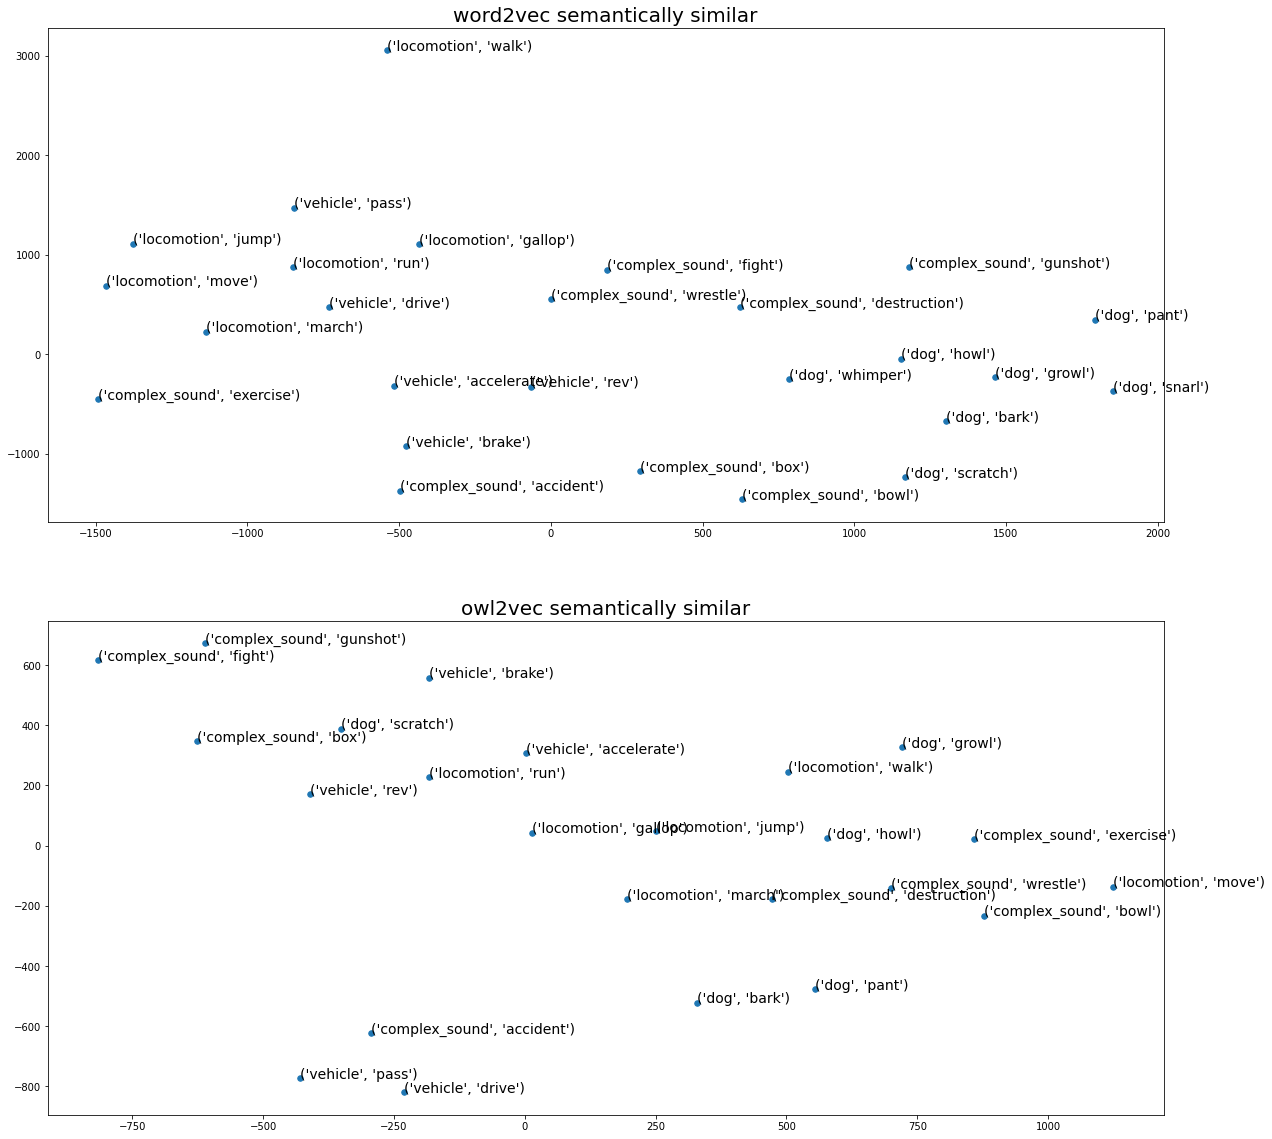

In [22]:
fig = plt.figure(figsize=(20,20))
    
# plotting w2v_df
fig.add_subplot(2,1,1)
plotting(w2v_sem_df, initiate_tsne(w2v_sem_df), "word2vec semantically similar")

# plotting o2v_df
fig.add_subplot(2,1,2)
plotting(o2v_sem_df, initiate_tsne(o2v_sem_df), "owl2vec semantically similar")

plt.show() 

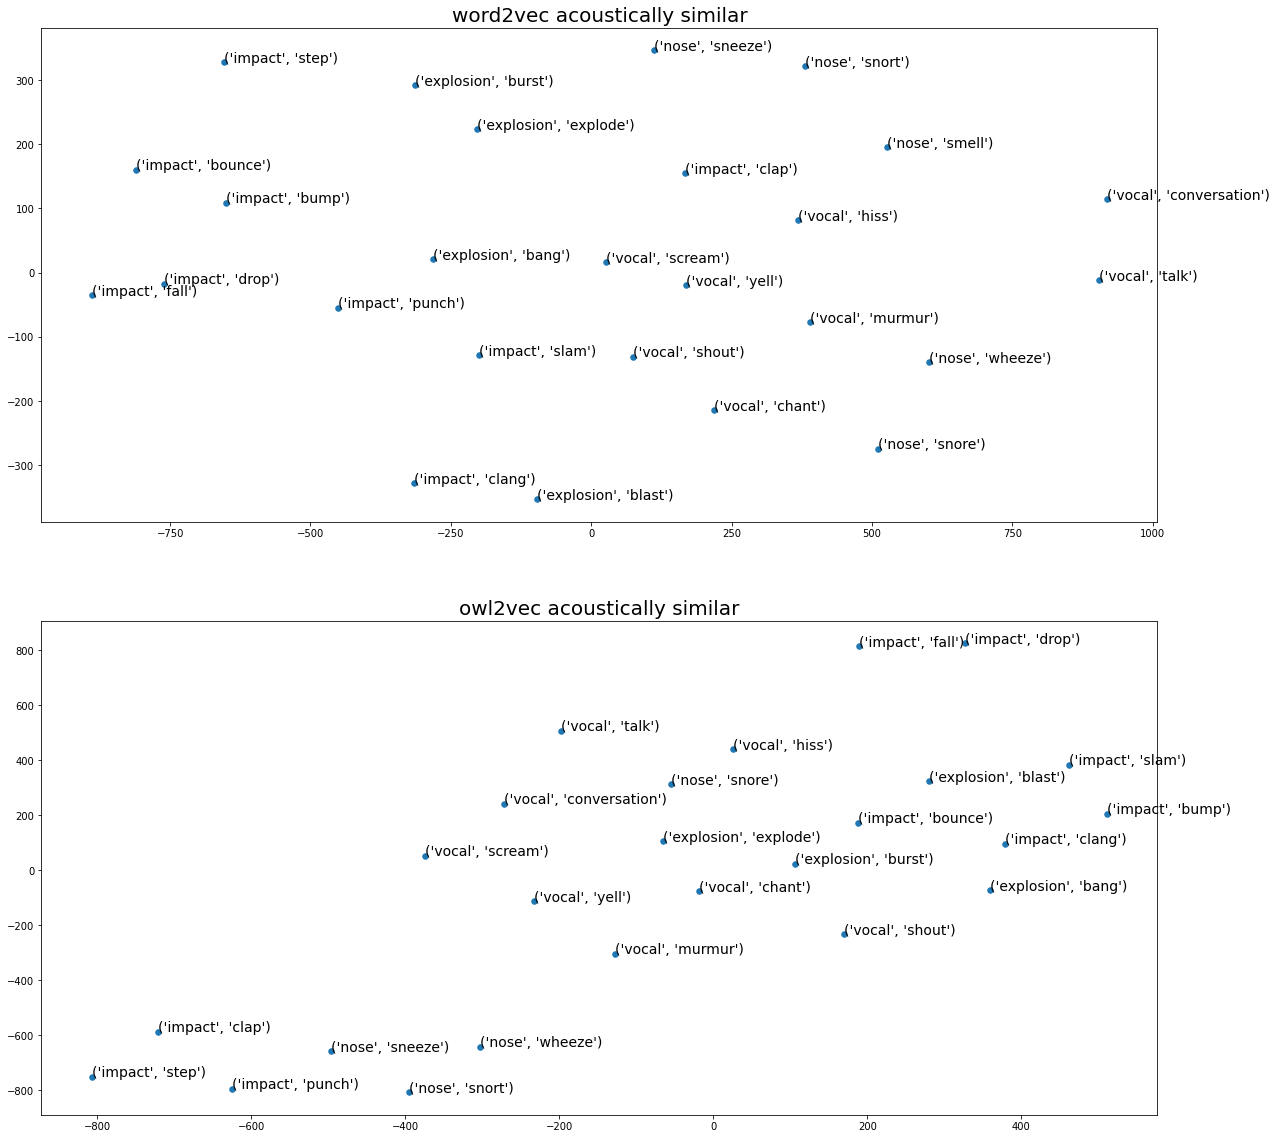

In [23]:
fig = plt.figure(figsize=(20,20))
    
# plotting w2v_df
fig.add_subplot(2,1,1)
plotting(w2v_aco_df, initiate_tsne(w2v_aco_df), "word2vec acoustically similar")

# plotting o2v_df
fig.add_subplot(2,1,2)
plotting(o2v_aco_df, initiate_tsne(o2v_aco_df), "owl2vec acoustically similar")

plt.show() 